In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

# Data Management
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Machine Learning
# https://xgboost.readthedocs.io/en/stable/parameter.html
from xgboost import XGBClassifier
#RandomizedSerchCV for finding the best parameters
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold

# Evaluation
from sklearn.metrics import precision_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

#plot_roc_curve is removed
# https://stackoverflow.com/questions/60321389/sklearn-importerror-cannot-import-name-plot-roc-curve
from sklearn.metrics import RocCurveDisplay

#Reporting
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from xgboost import plot_tree


### Data Management

In [2]:
df = pd.read_csv("data/BTC-USD.csv")
df.set_index("Date", inplace=True)
df.head(3)

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,...,MA_21,DOW,Roll_Rets,Avg_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-31,0.000878,0.053054,0.001615,970.403015,1.103895,0.054348,0.055442,-0.029463,60.205366,1.192634,...,885.613522,1,0.011408,0.057910,0.000964,0.003887,1.003974,-0.002272,0.004646,0.991144
2017-02-01,0.054272,0.017587,0.054056,989.023010,-0.087932,0.019188,0.018926,-0.009863,63.109498,1.048237,...,895.673808,2,0.007132,0.057381,0.054348,0.055442,1.192634,0.000964,0.003887,1.003974
2017-02-02,0.019630,0.024675,0.012855,1011.799988,-0.028572,0.023030,0.030816,0.012600,66.345006,1.051268,...,905.529332,3,0.008542,0.057675,0.019188,0.018926,1.048237,0.054348,0.055442,1.192634


### Prediction Target

In [3]:
# Specify Target
df.loc[df["Range"].shift(-1) > df["Avg_Range"], "TARGET"]  = 1
df.loc[df["Range"].shift(-1) <= df["Avg_Range"], "TARGET"]  = 0



In [4]:
### Fill NA
df["TARGET"].fillna(0, inplace=True)
df.tail()

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,...,DOW,Roll_Rets,Avg_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2,TARGET
Date,,,,,,,,,,,,,,,,,,,,,
2022-05-26,-0.002980,-0.010731,-0.038218,29267.224609,0.336031,-0.009984,0.055632,33.189608,38.165993,0.977232,...,3,-0.239867,0.057147,-0.003144,0.026300,0.993166,0.019130,0.034313,1.065192,0.0
2022-05-27,-0.010608,-0.016331,0.002290,28627.574219,-0.005230,-0.021856,0.036020,32.436595,36.240181,0.949541,...,4,-0.291202,0.057119,-0.009984,0.055632,0.977232,-0.003144,0.026300,0.993166,0.0
2022-05-28,-0.021487,-0.018129,0.008047,28814.900391,-0.029042,0.006544,0.009117,32.894788,37.238957,1.027560,...,5,-0.298233,0.056286,-0.021856,0.036020,0.949541,-0.009984,0.055632,0.977232,0.0
2022-05-29,0.013879,0.023707,0.010035,29445.957031,-0.490594,0.021900,0.022777,33.634047,40.613855,1.090628,...,6,-0.247068,0.055605,0.006544,0.009117,1.027560,-0.021856,0.036020,0.949541,1.0
2022-05-30,0.014593,0.083111,0.016035,31726.390625,1.170788,0.077445,0.090298,36.313300,50.890862,1.253042,...,0,-0.146443,0.057666,0.021900,0.022777,1.090628,0.006544,0.009117,1.027560,0.0


In [5]:
df_tts = df.copy()
df_tts = df_tts[['Returns', 'Range', "RSI", "RSI_Ret", "Returns_T1", "RSI_Ret_T1", "TARGET"]]

In [6]:
# Split into X and Y Data
X = df_tts.iloc[:, :-1]
y = df_tts.iloc[:, -1]

In [7]:
# Perform Train Test Split (TimeSeries)
train_size_rate = 0.7
train_size = int(len(X) * train_size_rate)
test_size = len(X) - train_size

X_train = X.head(train_size)
y_train = y.head(train_size)

X_test = X.tail(test_size)
y_test = y.tail(test_size)

size_check = len(y_test) + len(y_train) == len(X)
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)
print("Size Maches: ", size_check)


Shape of X_train:  (1362, 6)
Shape of y_train:  (1362,)
Shape of X_test:  (584, 6)
Shape of y_test:  (584,)
Size Maches:  True


In [8]:
# Slect type of model to optimise for
is_binary = True
is_optimized_for_precision = True

In [9]:
# Determine Objective and Eval Metrics
if is_binary:
    objective = "binary:logistic"
    eval_metric = "logloss"
    eval_metric_list = ["error", "logloss", eval_metric]
else:
    objective = "multi:softmax"
    eval_metric = "mlogloss"
    eval_metric_list = ["merror", "mlogloss", eval_metric]

In [10]:
# Refine Eval Metric
if is_binary and is_optimized_for_precision:
    eval_metric = "aucpr"
    scoring = "precision"
elif is_binary and not is_optimized_for_precision:
    eval_metric = "auc"
    scoring = "f1"
else:
    scoring = "accuracy"

In [11]:
# Hyperparams: ne: 80, lr: 0.01 md: 3 gm: 6
ne = 80
lr = 0.01
md = 3
gm = 6

In [12]:
# XGBOOST Classifier
classifier = XGBClassifier(
    objective = objective, 
    booster = "gbtree",
    eval_metric=  eval_metric_list,
    n_estimators = ne,
    learning_rate = lr,
    max_depth = md,
    gamma = gm,
    subsample=0.8,
    colsample_bytree=1,
    random_state=1,
    # use_label_encoder=False
    )

In [13]:
eval_set = [(X_train, y_train), (X_test, y_test)]
classifier.fit(X_train, y_train,     eval_set=eval_set, verbose=False)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=['error', 'logloss', 'logloss'], feature_types=None,
              gamma=6, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=80, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)

### Make Prediction

In [14]:
# Get Predictions Training

In [15]:
train_yhat = classifier.predict(X_train)
train_yhat_proba = classifier.predict_proba(X_train)

print("Preds training data: \n", train_yhat[:10])
print("Preds Probability training data: \n", train_yhat_proba[:3])


Preds training data: 
 [0 0 0 0 0 0 0 0 0 1]
Preds Probability training data: 
 [[0.63648975 0.36351025]
 [0.633116   0.36688402]
 [0.60664034 0.39335963]]


In [16]:
test_yhat = classifier.predict(X_test)
test_yhat_proba = classifier.predict_proba(X_test)

print("Preds test data: \n", test_yhat[:10])
print("Preds Probability test data: \n", test_yhat_proba[:3])

Preds test data: 
 [1 1 1 1 1 1 1 1 1 0]
Preds Probability test data: 
 [[0.42001498 0.579985  ]
 [0.415174   0.584826  ]
 [0.415174   0.584826  ]]


In [17]:
# Set K-Fold Cross Validation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)



In [18]:
# Traning Results
train_results = cross_val_score(classifier, X_train, y_train, scoring=scoring, cv=cv, n_jobs=1)

### Evaluation Metrcs - Loss and Ovefitting

In [19]:
# Retrieve performance metrics
results = classifier.evals_result()
epochs = len(results["validation_0"]["error"])
x_axis = range(0, epochs)

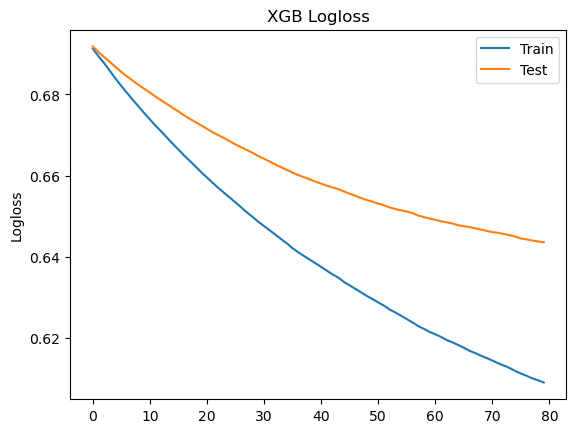

In [20]:
# Plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results["validation_0"]["logloss"], label="Train")
ax.plot(x_axis, results["validation_1"]["logloss"], label="Test")
ax.legend()
plt.ylabel("Logloss")
plt.title("XGB Logloss")
plt.show()

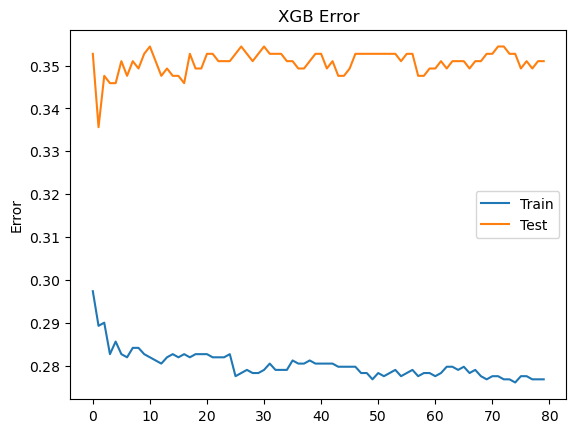

In [21]:
# Plot error
fig, ax = plt.subplots()
ax.plot(x_axis, results["validation_0"]["error"], label="Train")
ax.plot(x_axis, results["validation_1"]["error"], label="Test")
ax.legend()
plt.ylabel("Error")
plt.title("XGB Error")
plt.show()

### Evaluation Metrics - ROC Curve

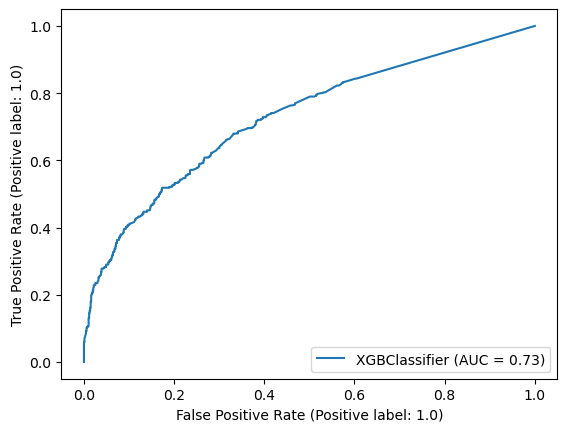

In [22]:
# Plot Training ROC Curve
xgb_disp = RocCurveDisplay.from_estimator(classifier, X_train,y_train)

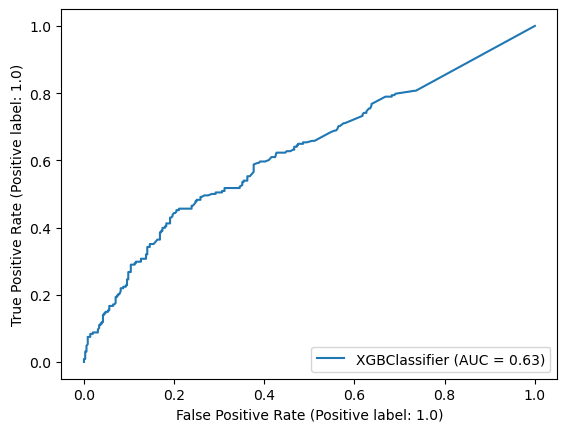

In [23]:
# Plot Test ROC Curve
xgb_disp = RocCurveDisplay.from_estimator(classifier, X_test,y_test)
# the curve shows it struggling in data to find the perfect fit

### Performance Evaluation Comparison

In [24]:
# Set K-Fold Cross Validation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

In [25]:
# Training Results
train_results = cross_val_score(classifier, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
test_results = cross_val_score(classifier, X_test, y_test, scoring=scoring, cv=cv, n_jobs=-1)


In [26]:
# Comparison of Results
print("TRAIN:")
print("Average Accuracy K-Fold", round(train_results.mean(), 2))
print("Std Dev K-Fold", round(train_results.std(), 2))
print("Precision Score 0", round(precision_score(y_train, train_yhat, average=None)[0], 3))
print("Precision Score 1", round(precision_score(y_train, train_yhat, average=None)[1], 3))
print("----- ----- ----- ----- ----- ----- ----- ----- -----")
print("TEST:")
print("Average Accuracy K-Fold", round(test_results.mean(), 2))
print("Std Dev K-Fold", round(test_results.std(), 2))
print("Precision Score 0", round(precision_score(y_test, test_yhat, average=None)[0], 3))
print("Precision Score 1", round(precision_score(y_test, test_yhat, average=None)[1], 3))

TRAIN:
Average Accuracy K-Fold 0.66
Std Dev K-Fold 0.06
Precision Score 0 0.722
Precision Score 1 0.727
----- ----- ----- ----- ----- ----- ----- ----- -----
TEST:
Average Accuracy K-Fold 0.61
Std Dev K-Fold 0.11
Precision Score 0 0.663
Precision Score 1 0.595


### Evaluation Metrics - Summary Report

- we want the precision higher, if there are no trading opportunity, that is fine, but if there is an opportunity, we want to predict more correct than no.

In [27]:
# Show Summayr report - Training
print(classification_report(y_train, train_yhat))

              precision    recall  f1-score   support

         0.0       0.72      0.92      0.81       872
         1.0       0.73      0.37      0.49       490

    accuracy                           0.72      1362
   macro avg       0.72      0.65      0.65      1362
weighted avg       0.72      0.72      0.69      1362



In [28]:
# Show Summayr report - Training


print(classification_report(y_test, test_yhat))

              precision    recall  f1-score   support

         0.0       0.66      0.86      0.75       356
         1.0       0.60      0.32      0.41       228

    accuracy                           0.65       584
   macro avg       0.63      0.59      0.58       584
weighted avg       0.64      0.65      0.62       584



### Performance Evaluation - Confusion Matrix

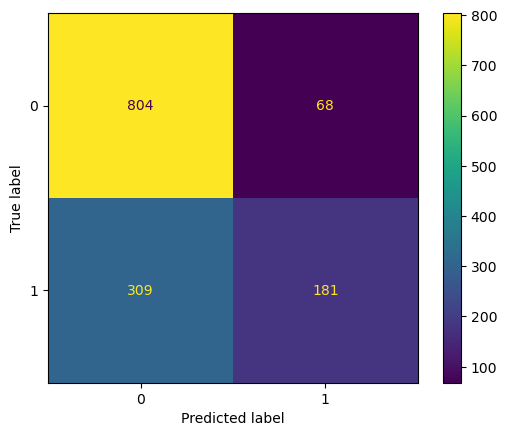

In [29]:
# Training Confusion Matrix
cm_train = confusion_matrix(y_train, train_yhat)
ConfusionMatrixDisplay(cm_train).plot()

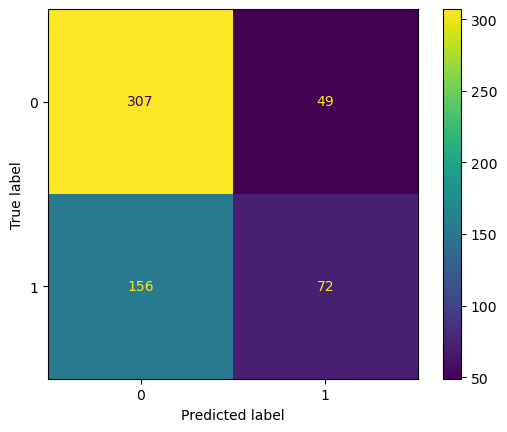

In [30]:
# Training Confusion Matrix
cm_test = confusion_matrix(y_test, test_yhat)
ConfusionMatrixDisplay(cm_test).plot()

### Feature Importance

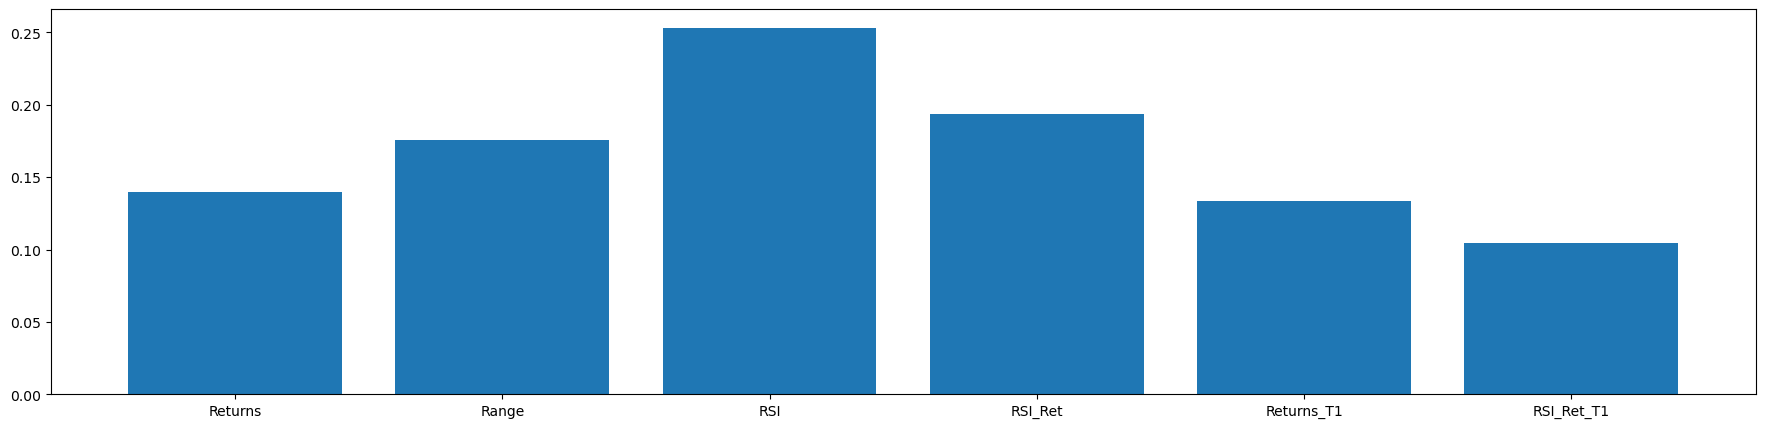

In [31]:
# Plot Feature Importances
fig = plt.figure(figsize=(22, 5))
importance_labels = X.columns
importance_features = classifier.feature_importances_
plt.bar(importance_labels, importance_features)
plt.show()

### XGBOOST TREE

ImportError: You must install graphviz to plot tree

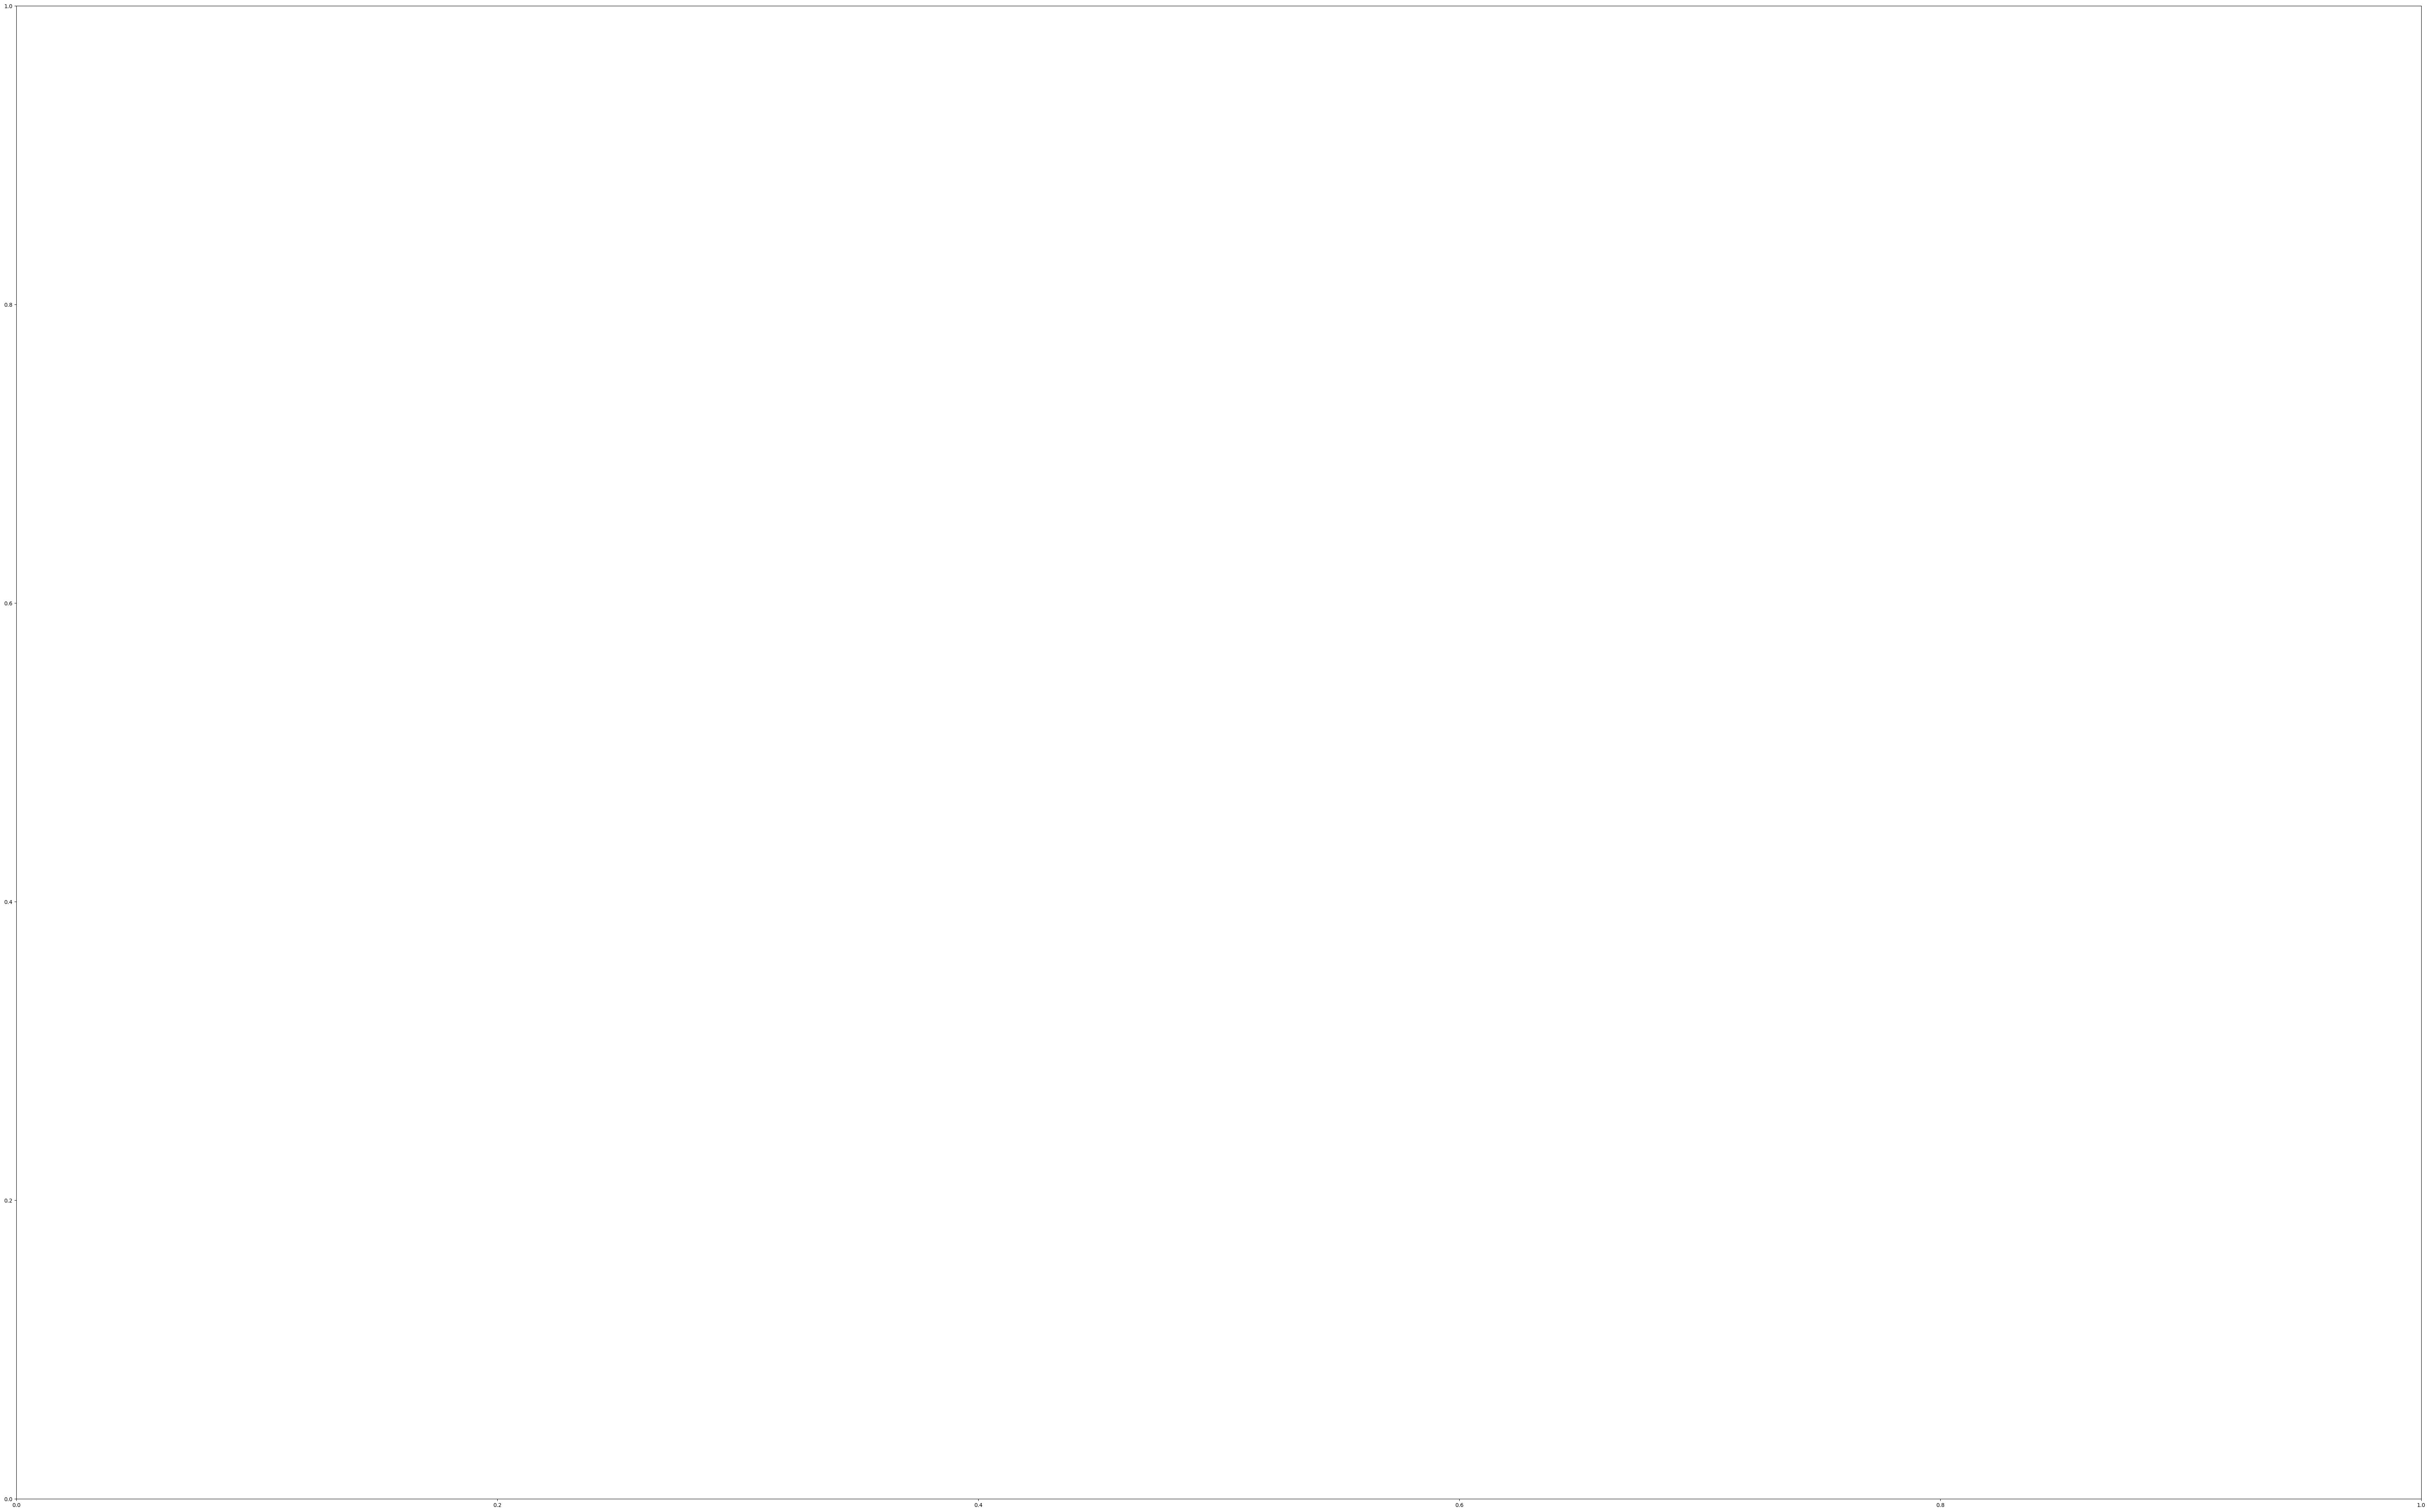

In [32]:
rcParams["figure.figsize"] = 80, 50
plot_tree(classifier)